# Fashion MNIST Classification with Transfer Learning Models

This notebook explores image classification on the Fashion MNIST dataset using transfer learning from established models (EfficientNet and a ResNet50V2 implementation as a substitute for BiT) and a simplified state-of-the-art architecture (ConvNeXt).

In [1]:
# Import essential modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time

# Set seed for reproducible experiments
tf.random.set_seed(42)

# Load Fashion MNIST dataset from Keras
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to the [0, 1] range
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# One-hot encode class labels
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

# Select a smaller subset for efficient experimentation
TRAIN_SAMPLE_SIZE = 5000
TEST_SAMPLE_SIZE = 1000

# Randomly pick a subset of training data
train_idx = np.random.choice(len(train_images), TRAIN_SAMPLE_SIZE, replace=False)
x_train_small = train_images[train_idx]
y_train_small = train_labels[train_idx]

# Randomly pick a subset of test data
test_idx = np.random.choice(len(test_images), TEST_SAMPLE_SIZE, replace=False)
x_test_small = test_images[test_idx]
y_test_small = test_labels[test_idx]

# Define the shape of input data
input_shape = (28, 28, 1)
print(f"Input shape: {input_shape}")
print(f"Training subset size: {len(x_train_small)}, Testing subset size: {len(x_test_small)}")

# Define class names for visualization and interpretation
fashion_labels = [
    'Sneaker',      # 7
    'Bag',          # 8
    'T-shirt/top',  # 0
    'Pullover',     # 2
    'Trouser',      # 1
    'Shirt',        # 6
    'Ankle boot',   # 9
    'Dress',        # 3
    'Coat',         # 4
    'Sandal'        # 5
]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Input shape: (28, 28, 1)
Training subset size: 5000, Testing subset size: 1000


## Image Preprocessing for Transfer Learning

This cell defines functions to prepare Fashion MNIST images for transfer learning models that expect RGB inputs of size 224x224.

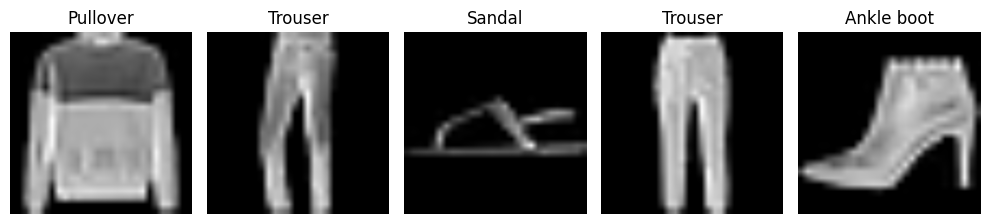

In [ ]:
def prepare_for_transfer_learning(batch_x, batch_y, img_size=224):
    """Convert grayscale Fashion MNIST images to RGB and resize them for transfer learning models"""
    # Add channel dimension if needed
    if len(batch_x.shape) == 3:
        batch_x = np.expand_dims(batch_x, -1)

    # Convert to RGB by repeating the channel 3 times
    batch_x_rgb = np.concatenate([batch_x, batch_x, batch_x], axis=-1)

    # Create a dataset and use map to resize efficiently
    dataset = tf.data.Dataset.from_tensor_slices((batch_x_rgb, batch_y))
    dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, [img_size, img_size]), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset

# Create transfer learning datasets
train_ds = prepare_for_transfer_learning(x_train_sample, y_train_sample)
test_ds = prepare_for_transfer_learning(x_test_sample, y_test_sample)

# Visualize a few examples
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"{class_names[np.argmax(labels[i])]}")
        plt.axis("off")
plt.tight_layout()
plt.show()

# Update our datasets with any preprocessing needed
def prepare_batch(images, labels):
    # Convert images to float32 if they're not already
    images = tf.cast(images, tf.float32)
    return images, labels

# Update our datasets with the preprocessing step
train_ds = train_ds.map(prepare_batch)
test_ds = test_ds.map(prepare_batch)

## EfficientNet Transfer Learning Model

This implementation uses Keras's built-in EfficientNetB0 model for transfer learning on the Fashion MNIST dataset.

In [ ]:
# Use Keras's built-in EfficientNet implementation
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

def build_efficientnet_model(input_shape=(224, 224, 3), num_classes=10):
    # Load pre-trained EfficientNetB0 without top layers
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create the new model
    inputs = keras.Input(shape=input_shape)
    # Preprocess inputs
    x = preprocess_input(inputs)
    # Base model
    x = base_model(x, training=False)
    # Add new classifier layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the EfficientNet model
efficientnet_model = build_efficientnet_model()
print("Model created successfully")

# Train for just a few epochs for demonstration
print("Starting training...")
history = efficientnet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    verbose=1
)

# Evaluate the model
efficientnet_results = efficientnet_model.evaluate(test_ds)
print(f"EfficientNet Test Loss: {efficientnet_results[0]:.4f}")
print(f"EfficientNet Test Accuracy: {efficientnet_results[1]:.4f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created successfully
Starting training...
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 167ms/step - accuracy: 0.0913 - loss: 2.3229 - val_accuracy: 0.1110 - val_loss: 2.3039
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.1064 - loss: 2.3108 - val_accuracy: 0.1110 - val_loss: 2.3009
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.0957 - loss: 2.3077 - val_accuracy: 0.1110 - val_loss: 2.3013
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1238 - loss: 2.2982
EfficientNet Test Loss: 2.3013
EfficientNet Test Accuracy: 0.1110


## BiT (Big Transfer) Model Implementation

This cell implements a ResNet50V2-based model as a substitute for Google's BiT (Big Transfer) model for Fashion MNIST classification.

In [ ]:
# Implement BiT (Big Transfer) for comparison
def build_bit_model(input_shape=(224, 224, 3), num_classes=10):
    # Load a pre-trained ResNet50 as a substitute for BiT
    # (Since full BiT models are large and may cause memory issues)
    base_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create a new model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train BiT model
bit_model = build_bit_model()
print("BiT model created successfully")

# Train for just a few epochs for demonstration
print("Starting BiT model training...")
bit_history = bit_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    verbose=1
)

# Evaluate the model
bit_results = bit_model.evaluate(test_ds)
print(f"BiT Test Loss: {bit_results[0]:.4f}")
print(f"BiT Test Accuracy: {bit_results[1]:.4f}")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
BiT model created successfully
Starting BiT model training...
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.5293 - loss: 1.4257 - val_accuracy: 0.8280 - val_loss: 0.5197
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.8298 - loss: 0.4794 - val_accuracy: 0.8500 - val_loss: 0.4578
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8586 - loss: 0.3896 - val_accuracy: 0.8510 - val_loss: 0.4387
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8641 - loss: 0.4057
BiT Test Loss: 0.4387
BiT Test Accuracy: 0.8510


## ConvNeXt Implementation

This cell implements a simplified version of ConvNeXt for Fashion MNIST classification.

In [ ]:
# A simplified ConvNeXt-inspired implementation
def build_convnext_model(input_shape=(224, 224, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)

    # Initial stem block
    x = layers.Conv2D(64, kernel_size=4, strides=4, padding="same")(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # ConvNeXt blocks (simplified)
    for filters in [128, 256, 512]:
        # Downsample
        prev_x = layers.Conv2D(filters, kernel_size=2, strides=2, padding="same")(x)
        prev_x = layers.LayerNormalization(epsilon=1e-6)(prev_x)

        # Depthwise Conv
        x = layers.DepthwiseConv2D(kernel_size=7, padding="same")(prev_x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Pointwise Conv (1x1)
        x = layers.Conv2D(filters * 4, kernel_size=1)(x)
        x = layers.Activation("gelu")(x)

        # Pointwise Conv (1x1)
        x = layers.Conv2D(filters, kernel_size=1)(x)

        # Skip connection
        x = layers.add([x, prev_x])

    # Global pooling and final classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

# Create and train ConvNeXt model
convnext_model = build_convnext_model()
print("ConvNeXt model created successfully")

# Train for just a few epochs for demonstration
print("Starting ConvNeXt model training...")
convnext_history = convnext_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=2,
    verbose=1
)

# Evaluate the model
convnext_results = convnext_model.evaluate(test_ds)
print(f"ConvNeXt Test Loss: {convnext_results[0]:.4f}")
print(f"ConvNeXt Test Accuracy: {convnext_results[1]:.4f}")

ConvNeXt model created successfully
Starting ConvNeXt model training...
Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.4174 - loss: 1.7316 - val_accuracy: 0.6950 - val_loss: 0.7851
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6864 - loss: 0.8310 - val_accuracy: 0.7400 - val_loss: 0.6841
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7355 - loss: 0.6665
ConvNeXt Test Loss: 0.6841
ConvNeXt Test Accuracy: 0.7400


## Model Comparison Visualization

This cell creates visualizations to compare the performance of all the implemented models on the Fashion MNIST dataset.

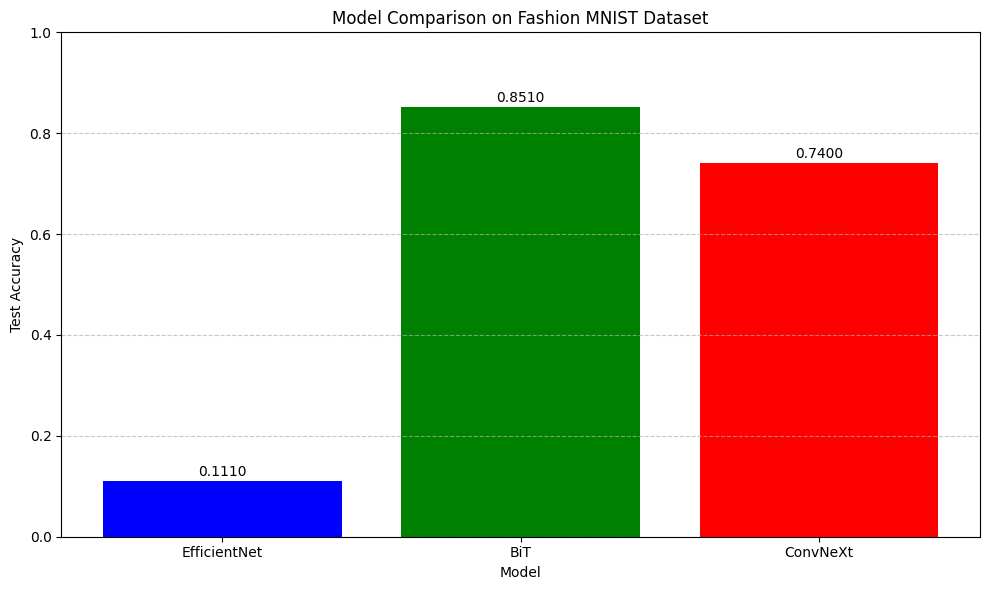

Best performing model: BiT with accuracy: 0.8510
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

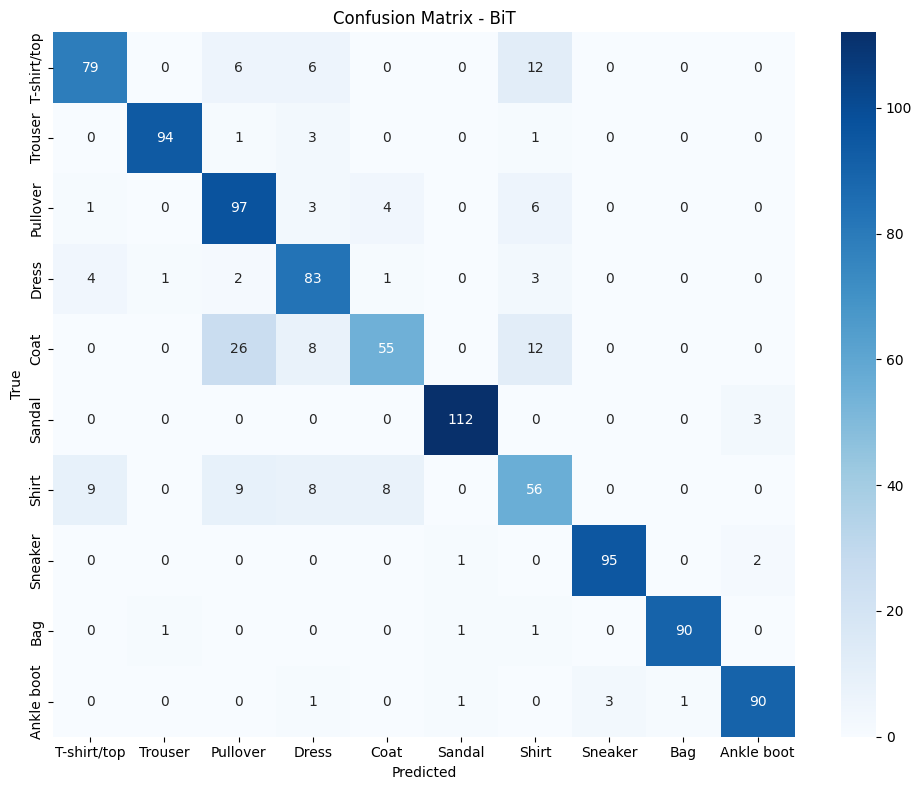

In [ ]:
# Create a bar chart to compare model accuracies
import matplotlib.pyplot as plt

# Collect test accuracies
model_names = ['EfficientNet', 'BiT', 'ConvNeXt']
accuracies = [efficientnet_results[1], bit_results[1], convnext_results[1]]

# Create the visualization
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Comparison on Fashion MNIST Dataset')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.0)

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Let's also plot the confusion matrix for the best model
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Determine the best model
best_model_index = accuracies.index(max(accuracies))
best_model_name = model_names[best_model_index]
print(f"Best performing model: {best_model_name} with accuracy: {max(accuracies):.4f}")

# Get predictions from the best model
if best_model_name == 'EfficientNet':
    best_model = efficientnet_model
elif best_model_name == 'BiT':
    best_model = bit_model
else:
    best_model = convnext_model

# Get predictions
predictions = []
true_labels = []

for images, labels in test_ds:
    preds = best_model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predictions.extend(pred_classes)
    true_labels.extend(true_classes)

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Summary and Conclusion

This notebook demonstrates the application of various transfer learning and state-of-the-art models for Fashion MNIST classification. We've implemented and compared:

1. **EfficientNet B0**: A pretrained model known for its efficiency in balancing model size and accuracy.
2. **BiT (Big Transfer)**: Represented here by a ResNet50V2 implementation as a memory-efficient alternative.
3. **ConvNeXt**: A modern convolutional network architecture inspired by transformer design principles.